In [12]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom ImageFolder to skip corrupted images
from torchvision.datasets import ImageFolder

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except Exception as e:
            print(f"Skipped corrupted image: {self.samples[index][0]}")
            new_index = (index + 1) % len(self)
            return self.__getitem__(new_index)

# Transform (resize + normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
dataset_path = 'dataset_split'  # Ganti dengan path sesuai
dataset = SafeImageFolder(root=os.path.join(dataset_path, 'train'), transform=transform)

# Train-val split (70-30)
train_len = int(0.7 * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [13]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 32x32x32
        x = self.pool(F.relu(self.conv2(x)))  # -> 64x16x16
        x = self.pool(F.relu(self.conv3(x)))  # -> 128x8x8
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=len(dataset.classes)).to(device)


In [14]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    return total_loss / len(loader), acc

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    return total_loss / len(loader), acc


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")


Epoch 1/30
Train Loss: 0.7763 | Train Acc: 74.93%
Val Loss: 2.4566 | Val Acc: 49.39%

Epoch 2/30
Train Loss: 0.5764 | Train Acc: 83.51%
Val Loss: 2.6989 | Val Acc: 48.47%

Epoch 3/30
Train Loss: 0.5773 | Train Acc: 81.40%
Val Loss: 2.6261 | Val Acc: 49.39%

Epoch 4/30
Train Loss: 0.4857 | Train Acc: 85.36%
Val Loss: 2.5419 | Val Acc: 49.69%

Epoch 5/30
Train Loss: 0.4709 | Train Acc: 86.15%
Val Loss: 2.5072 | Val Acc: 53.07%

Epoch 6/30
Train Loss: 0.4055 | Train Acc: 86.54%
Val Loss: 2.5900 | Val Acc: 50.31%

Epoch 7/30
Train Loss: 0.4337 | Train Acc: 86.54%
Val Loss: 2.6567 | Val Acc: 54.60%

Epoch 8/30
Train Loss: 0.3941 | Train Acc: 87.47%
Val Loss: 2.7049 | Val Acc: 49.08%

Epoch 9/30
Train Loss: 0.3391 | Train Acc: 89.58%
Val Loss: 3.2328 | Val Acc: 51.53%

Epoch 10/30
Train Loss: 0.3169 | Train Acc: 90.77%
Val Loss: 2.7805 | Val Acc: 53.99%

Epoch 11/30
Train Loss: 0.3320 | Train Acc: 90.90%
Val Loss: 2.6126 | Val Acc: 53.99%

Epoch 12/30
Train Loss: 0.2600 | Train Acc: 91.42%
V

Classification Report:
              precision    recall  f1-score   support

          ba       0.38      0.35      0.36        17
          ca       0.68      0.68      0.68        19
          da       0.50      0.38      0.43        16
         dha       0.21      0.25      0.23        12
          ga       0.75      0.62      0.68        24
          ha       0.45      0.68      0.54        19
          ja       0.85      0.92      0.88        12
          ka       0.83      0.83      0.83        18
          la       0.55      0.46      0.50        13
          ma       0.67      0.78      0.72        18
          na       0.67      0.71      0.69        14
         nga       0.40      0.47      0.43        17
         nya       0.59      0.59      0.59        17
          pa       0.20      0.33      0.25         9
          ra       0.87      0.81      0.84        16
          sa       0.47      0.42      0.44        19
          ta       0.78      0.44      0.56        16
    

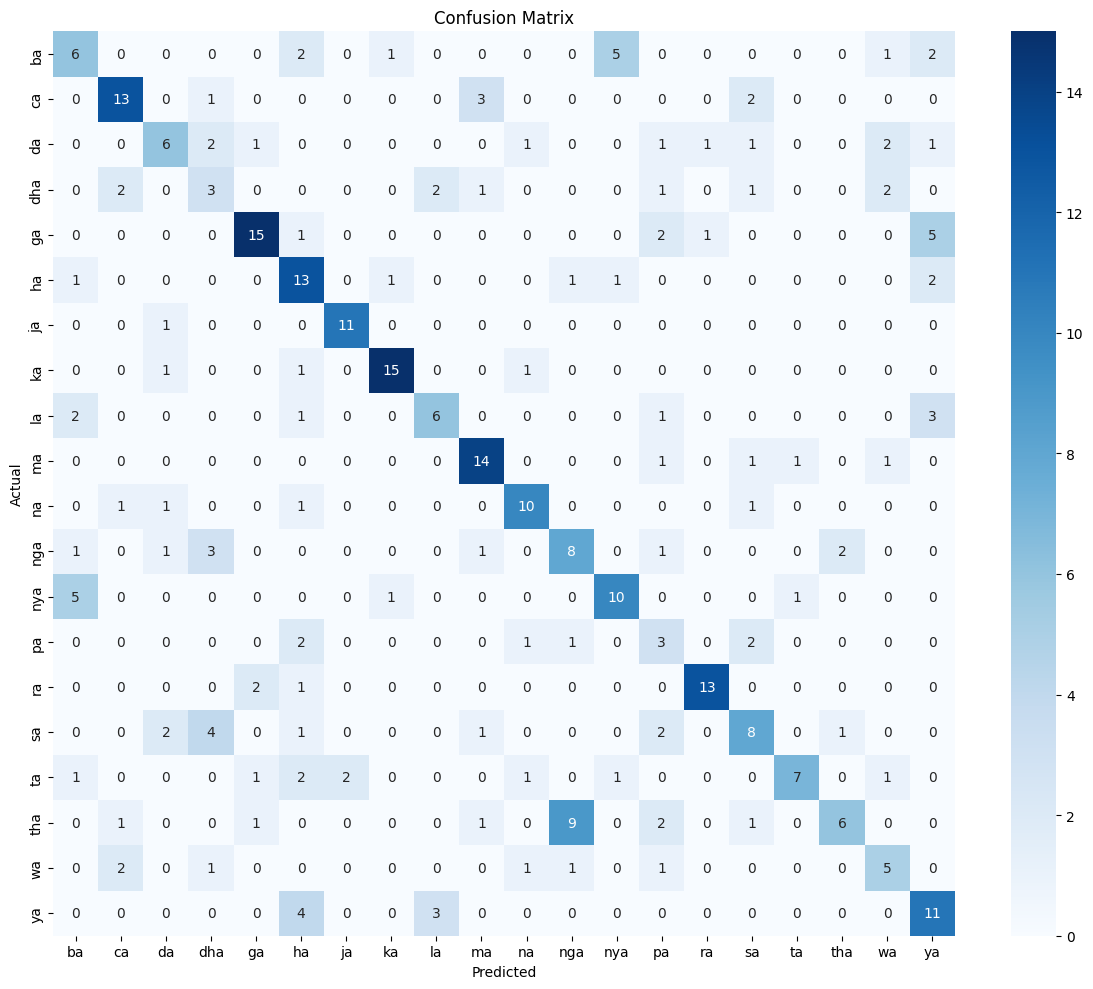

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Misal ini dataset asli sebelum di-split
# full_dataset = datasets.ImageFolder(root='dataset_split/train', transform=transform)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Ambil class names dari dataset asli
class_names = dataset.classes

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].


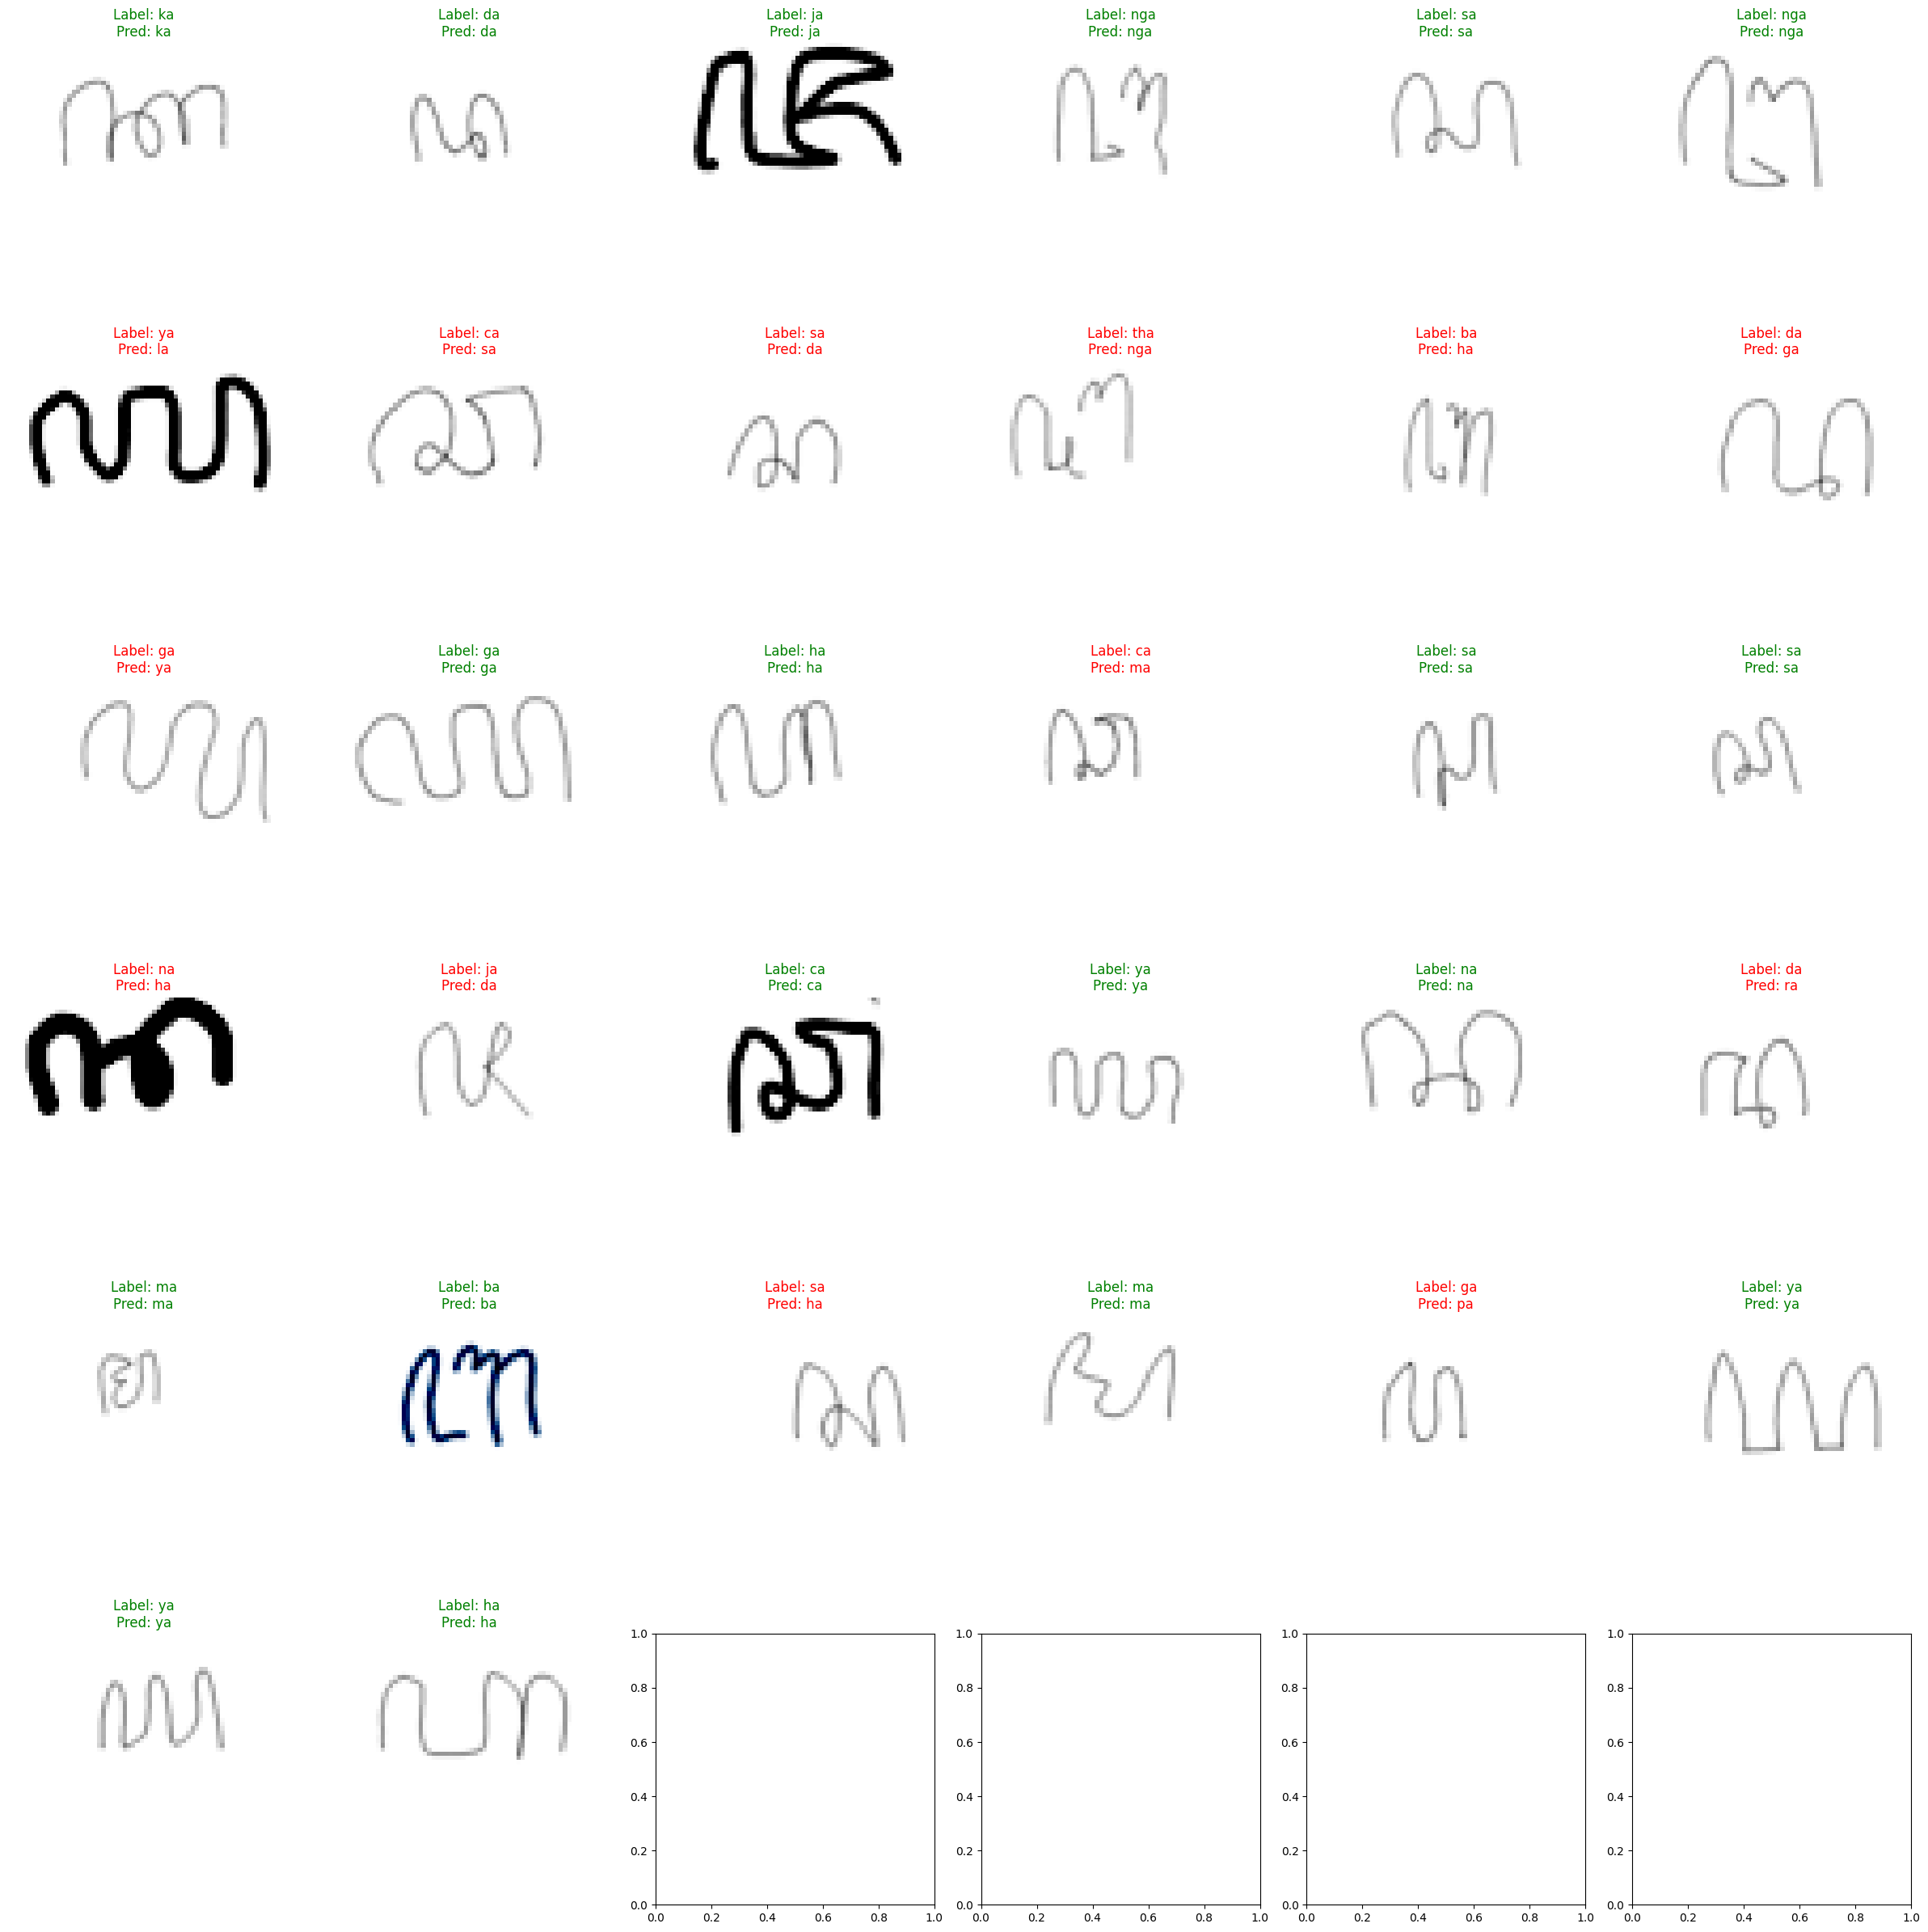

Jumlah prediksi benar: 19
Jumlah prediksi salah: 13
Rasio akurasi pada batch ini: 0.5938


In [27]:
# Buat mapping label ke kategori
label2cat = {i: c for i, c in enumerate(val_loader.dataset.dataset.classes)}  # jika val_loader adalah Subset

correct = 0
incorrect = 0

model.eval()

for features, targets in val_loader:
    features, targets = features.to(device), targets.to(device)

    with torch.no_grad():
        outputs = model(features)
        preds = outputs.argmax(dim=1)

    num_samples = min(36, features.size(0))
    indices = torch.randperm(features.size(0))[:num_samples]

    fig, axes = plt.subplots(6, 6, figsize=(24, 24))

    for img, label, pred, ax in zip(features[indices], targets[indices], preds[indices], axes.flatten()):
        img_np = img.cpu().permute(1, 2, 0).numpy()
        if img_np.shape[2] == 1:
            img_np = img_np.squeeze(2)
            ax.imshow(img_np, cmap='gray')
        else:
            ax.imshow(img_np)

        warna_font = 'g' if label == pred else 'r'
        label_name = label2cat[label.item()]
        pred_name = label2cat[pred.item()]
        ax.set_title(f"Label: {label_name}\nPred: {pred_name}", color=warna_font)
        ax.axis('off')

        if label == pred:
            correct += 1
        else:
            incorrect += 1

    plt.tight_layout()
    plt.show()

    break  # hanya 1 batch untuk visualisasi

print(f"Jumlah prediksi benar: {correct}")
print(f"Jumlah prediksi salah: {incorrect}")
print(f"Rasio akurasi pada batch ini: {correct / (correct + incorrect):.4f}")
